In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-25'

# SSRT by SSD

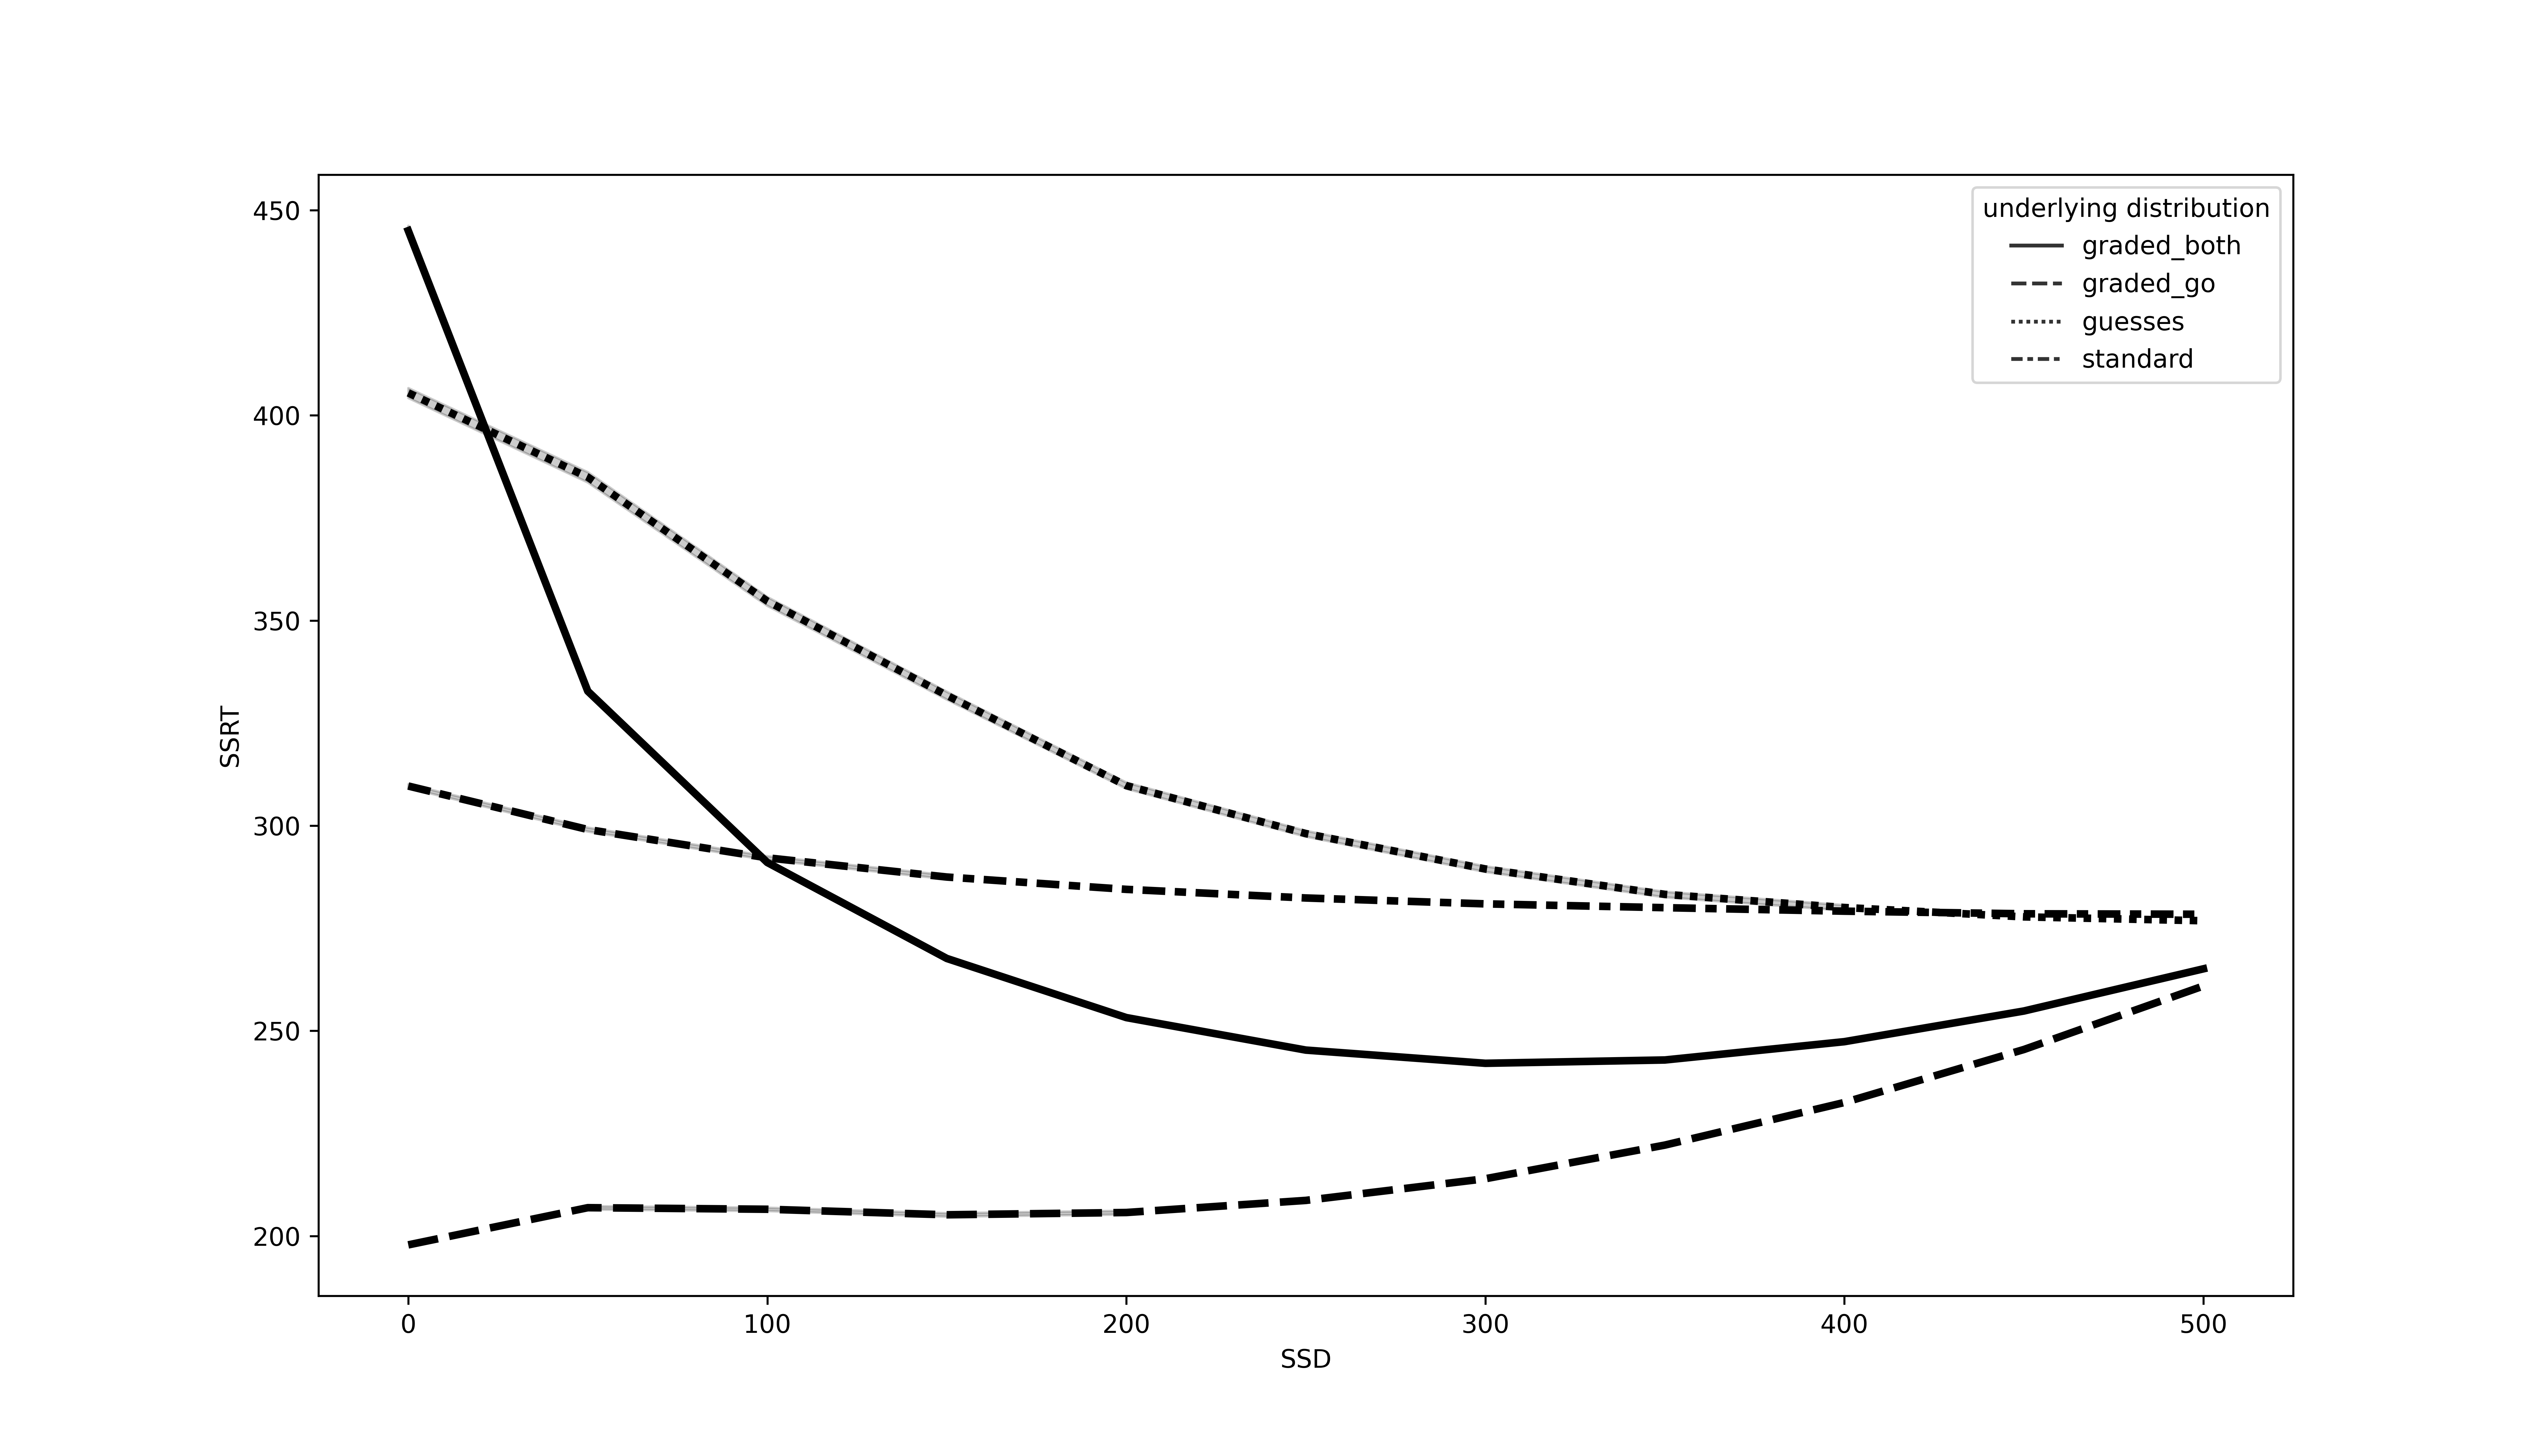

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

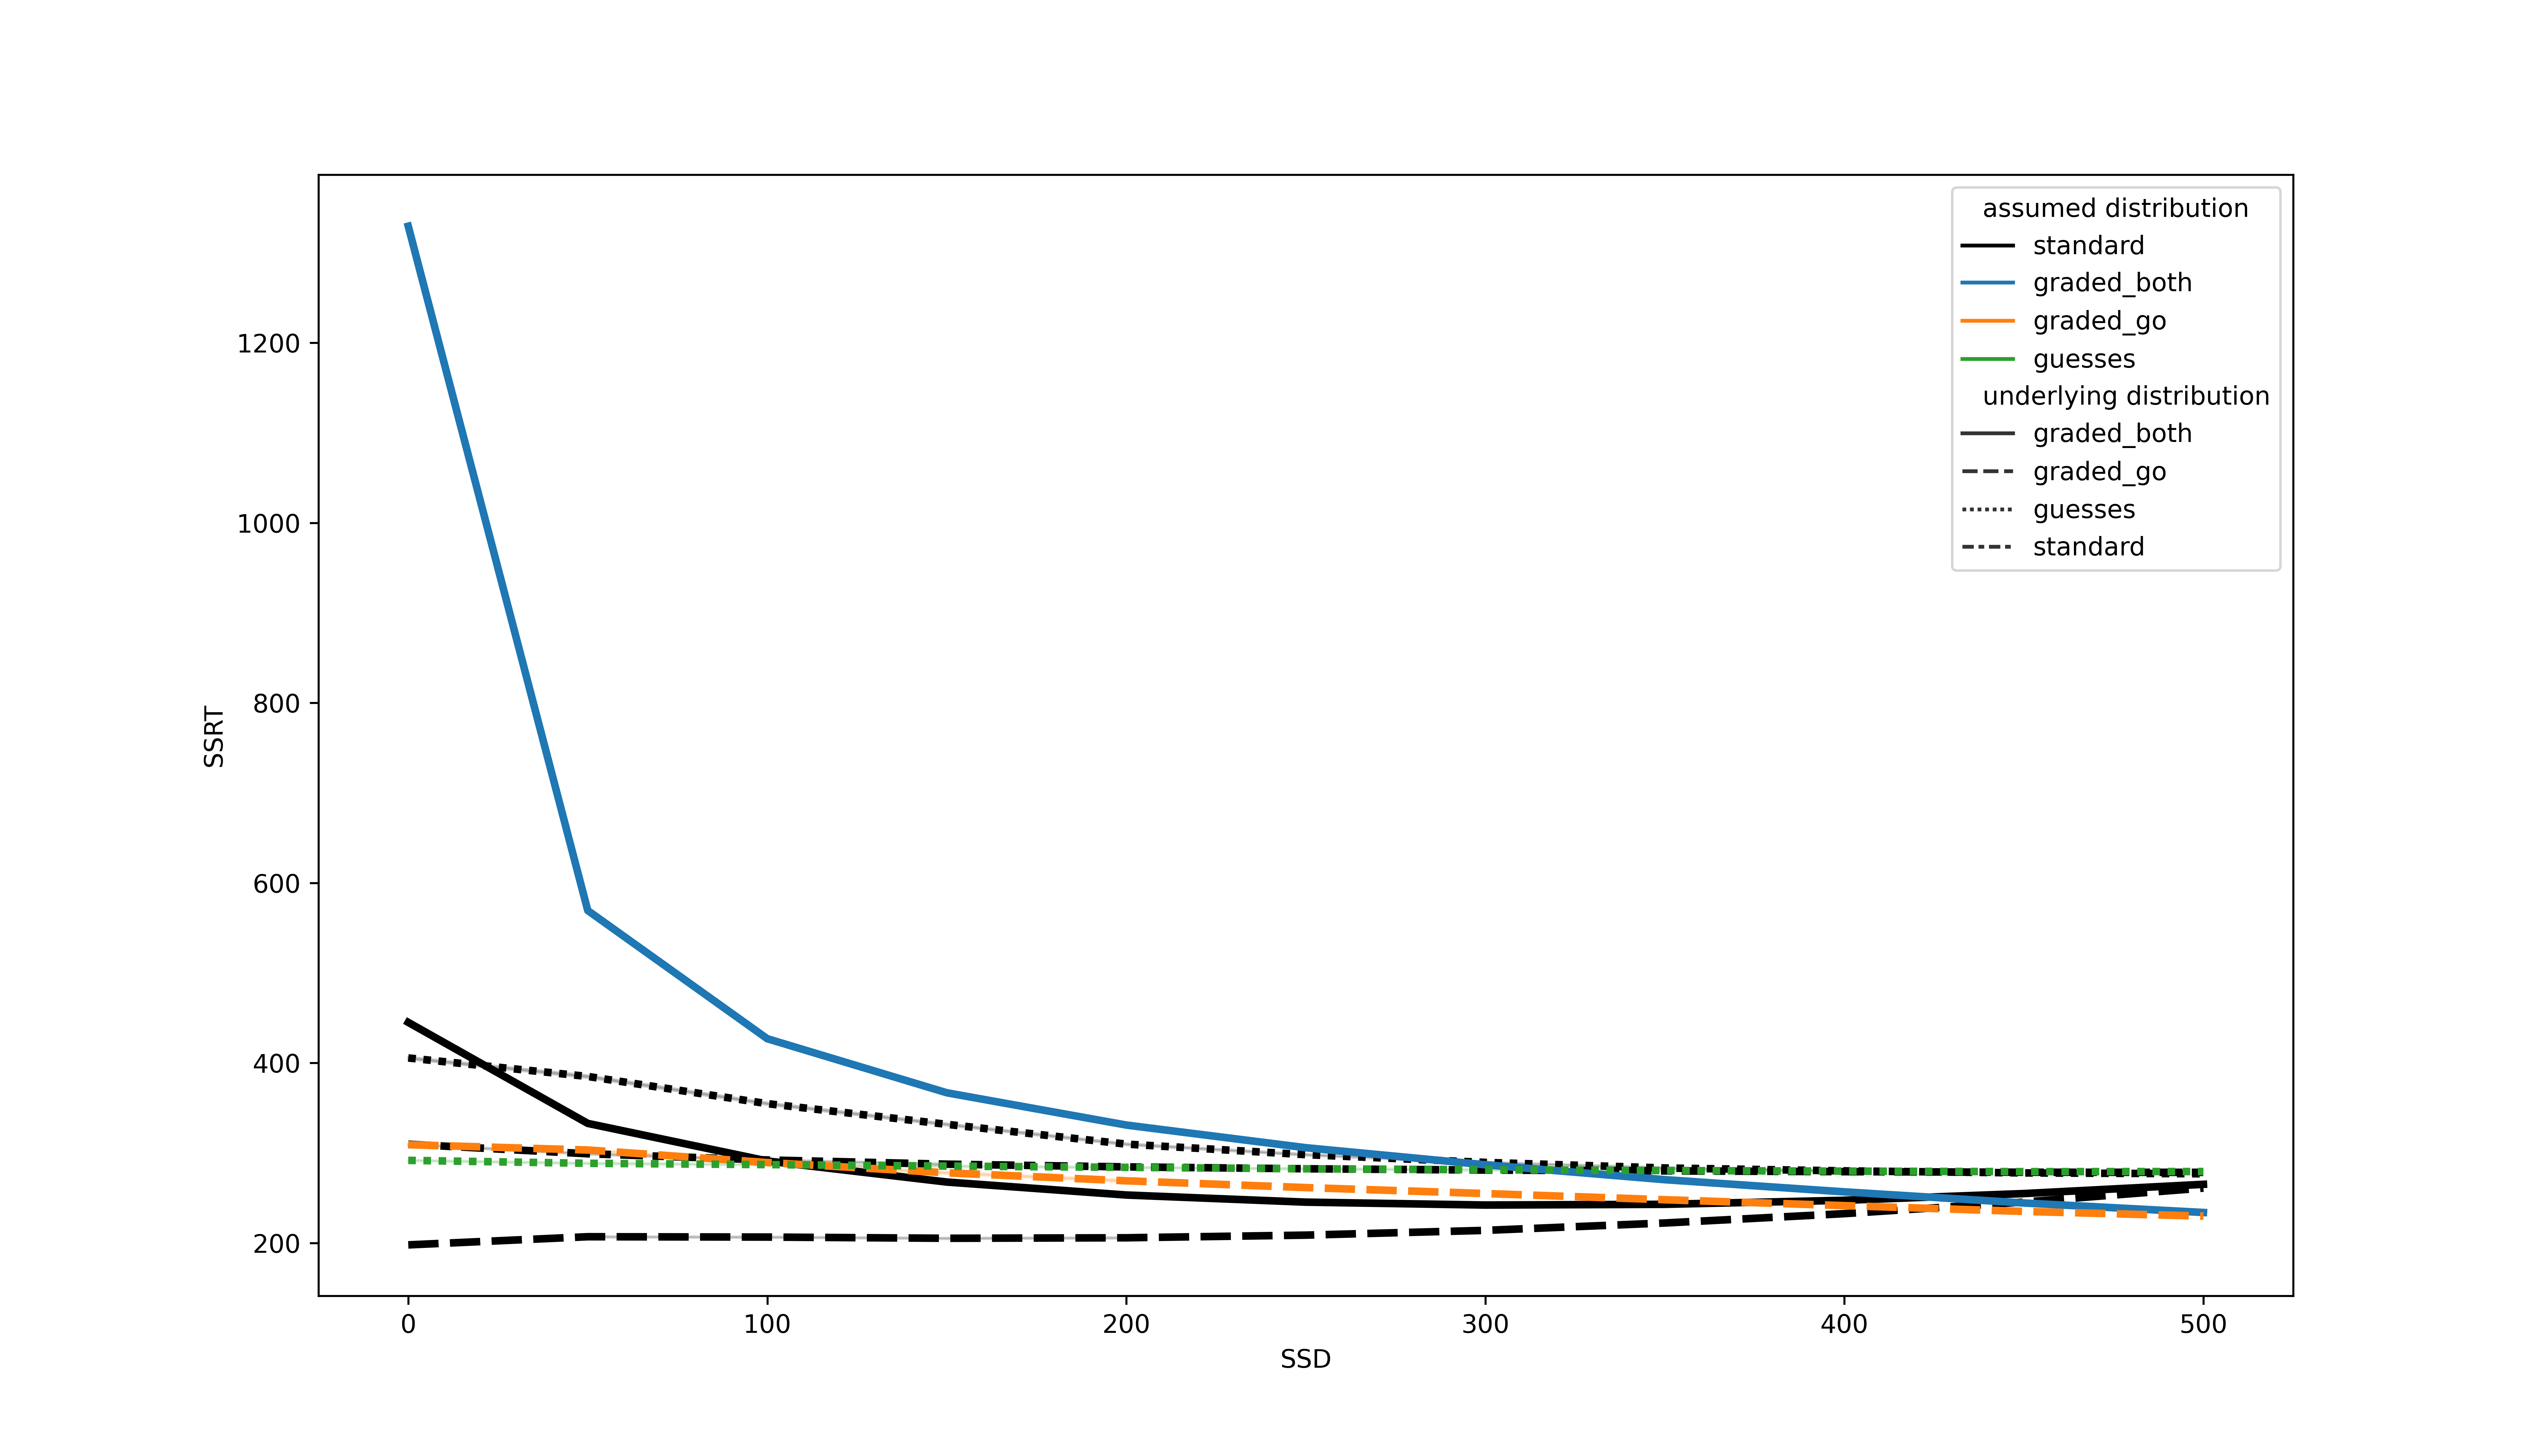

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

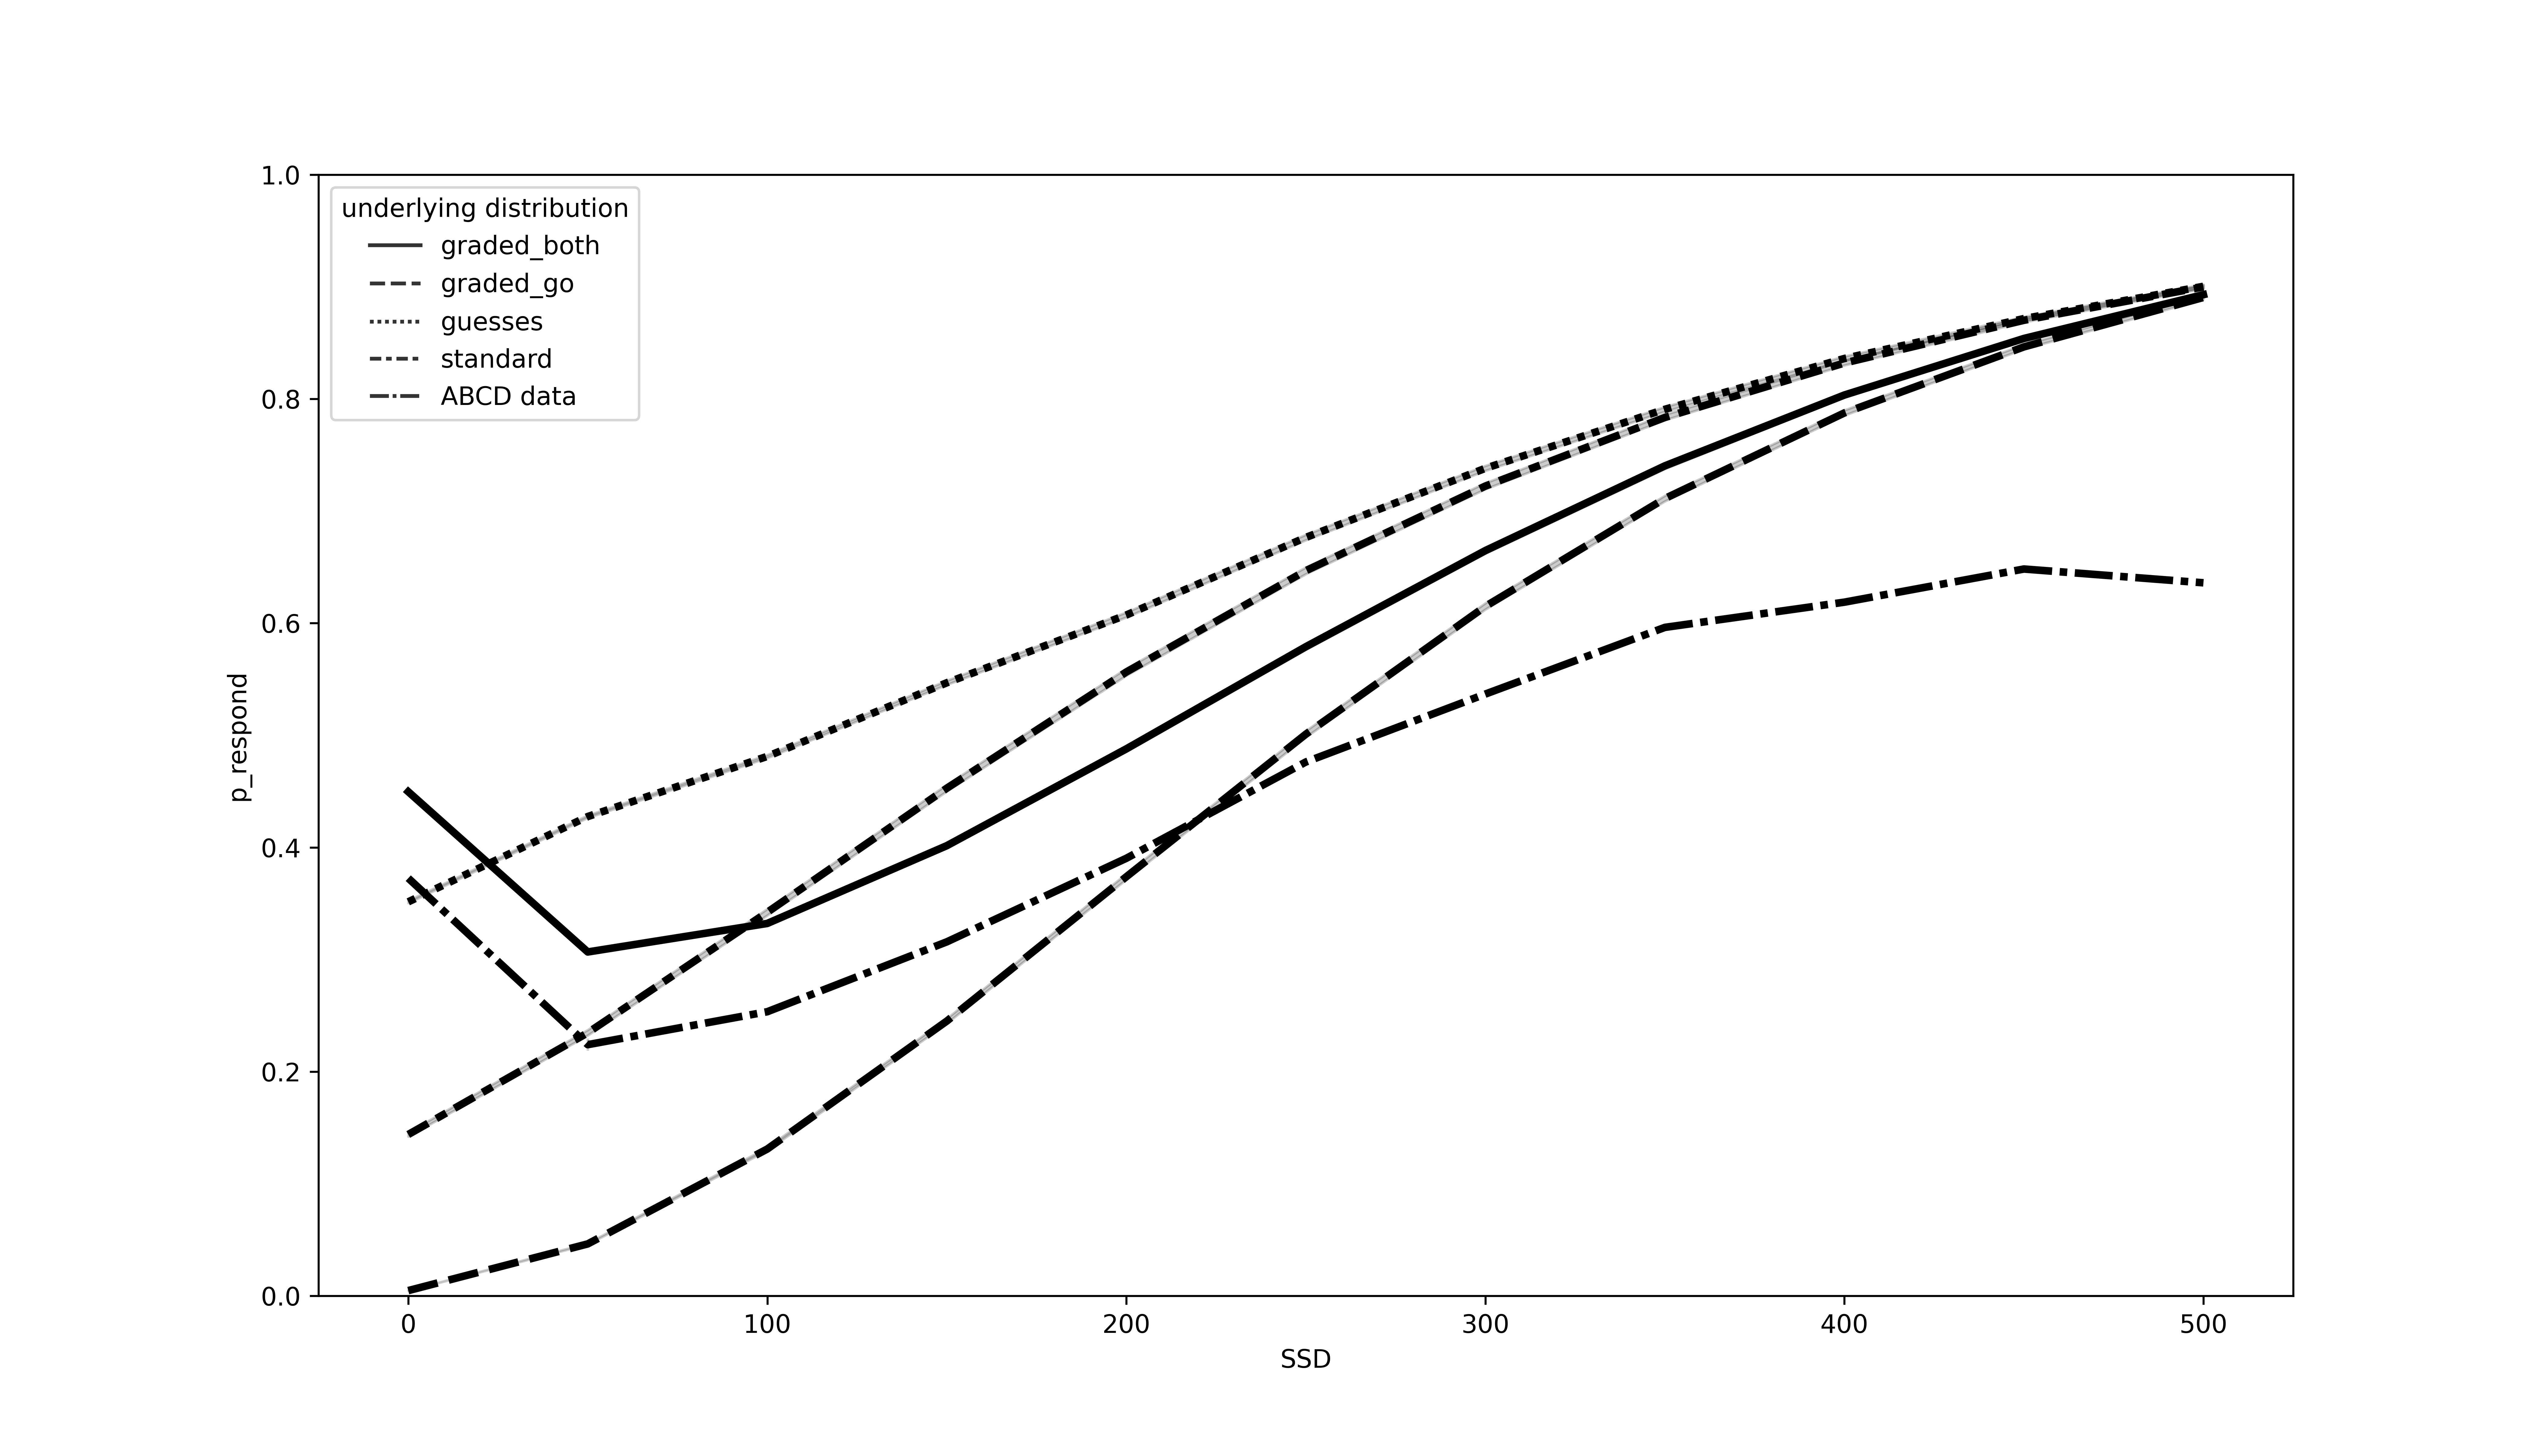

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)
    
# confirm that no kludge is required - check SSRTscale-0_RTscale-0 for use of kludge
tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1','gen-guesses_SSRT-tracking.2', 'gen-standard_SSRT-tracking.3']
for col in tracking_ssrts:
    assert sum(ssrt_df[col].isnull())==0

In [8]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [9]:
mus_df.head()

goRT        go        SSRT      stop
003RTV85  459.869390  0.243980  331.395005  0.355372
007W6H7B  368.809477  0.313667  261.141085  0.473617
00CY2MDM  449.321734  0.250425  305.961040  0.390684
00HEV6HB  408.030844  0.279306  306.748683  0.389486
00J52GPG  462.209942  0.242595  277.440297  0.439676

In [10]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [11]:
monster_df.shape

(8207, 28)

In [12]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

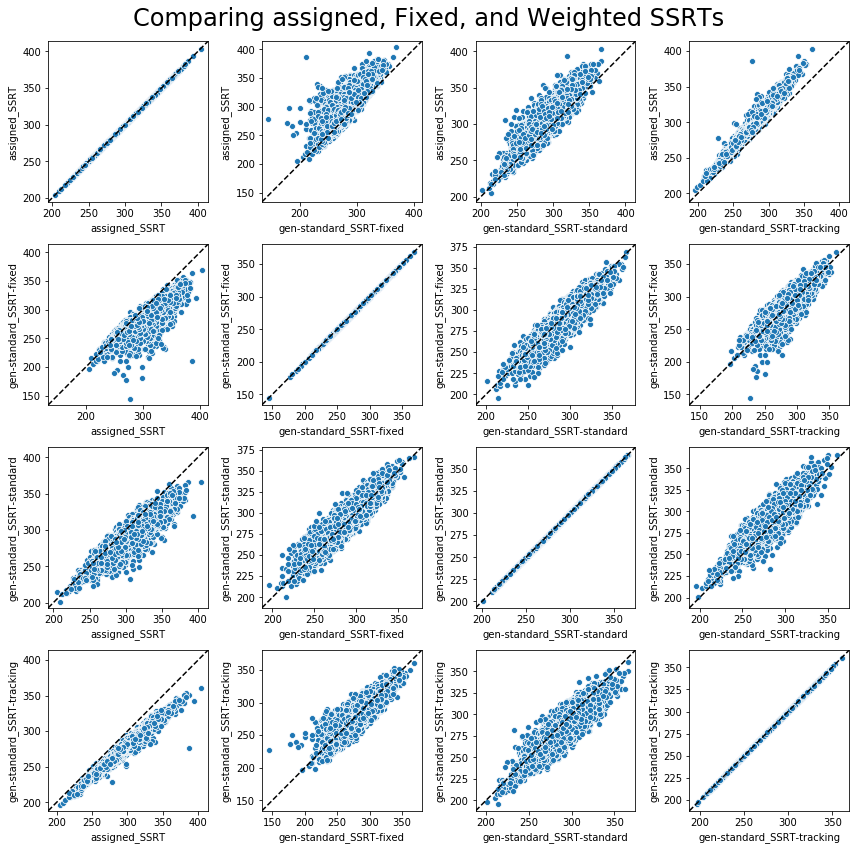

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [14]:
monster_df[columns].corr(method='spearman')

assigned_SSRT  gen-standard_SSRT-fixed  \
assigned_SSRT                    1.000000                 0.848127   
gen-standard_SSRT-fixed          0.848127                 1.000000   
gen-standard_SSRT-standard       0.894001                 0.915628   
gen-standard_SSRT-tracking       0.981597                 0.860241   

                            gen-standard_SSRT-standard  \
assigned_SSRT                                 0.894001   
gen-standard_SSRT-fixed                       0.915628   
gen-standard_SSRT-standard                    1.000000   
gen-standard_SSRT-tracking                    0.891614   

                            gen-standard_SSRT-tracking  
assigned_SSRT                                 0.981597  
gen-standard_SSRT-fixed                       0.860241  
gen-standard_SSRT-standard                    0.891614  
gen-standard_SSRT-tracking                    1.000000

# Comparing Fixed SSRTs

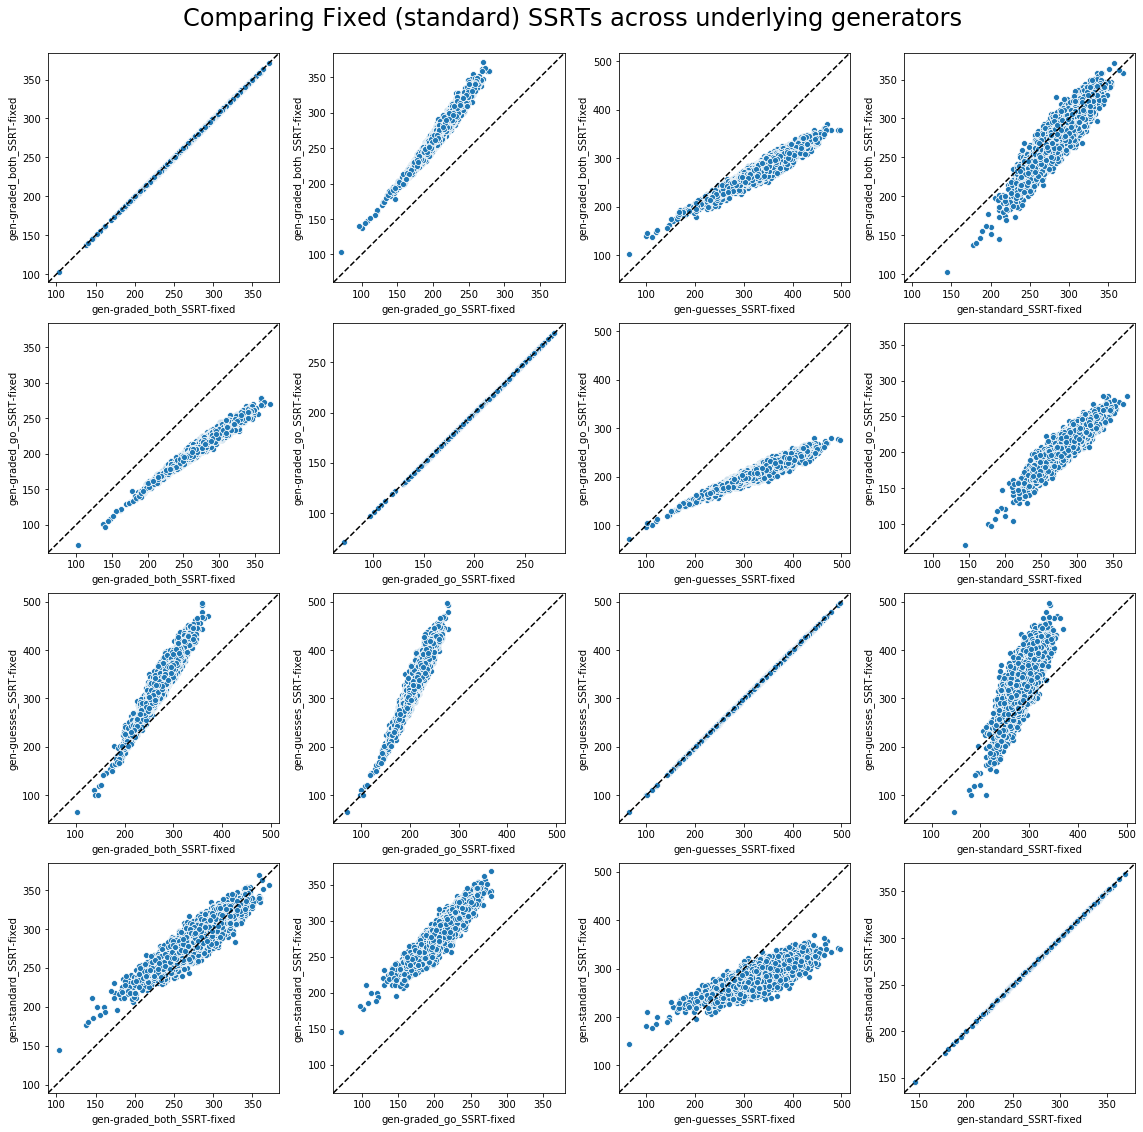

In [15]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [16]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-fixed  \
gen-graded_both_SSRT-fixed                    1.000000   
gen-graded_go_SSRT-fixed                      0.977402   
gen-guesses_SSRT-fixed                        0.952678   
gen-standard_SSRT-fixed                       0.890478   

                            gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
gen-graded_both_SSRT-fixed                  0.977402                0.952678   
gen-graded_go_SSRT-fixed                    1.000000                0.943689   
gen-guesses_SSRT-fixed                      0.943689                1.000000   
gen-standard_SSRT-fixed                     0.895976                0.765179   

                            gen-standard_SSRT-fixed  
gen-graded_both_SSRT-fixed                 0.890478  
gen-graded_go_SSRT-fixed                   0.895976  
gen-guesses_SSRT-fixed                     0.765179  
gen-standard_SSRT-fixed                    1.000000

## (not rescaling the axes to get a closer look)

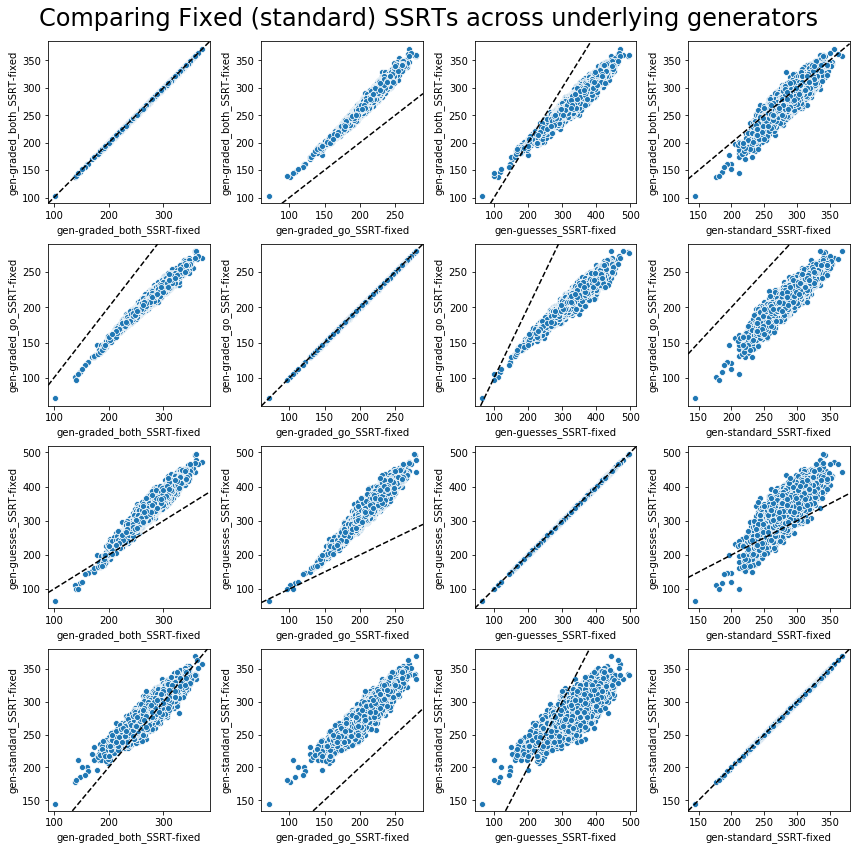

In [17]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

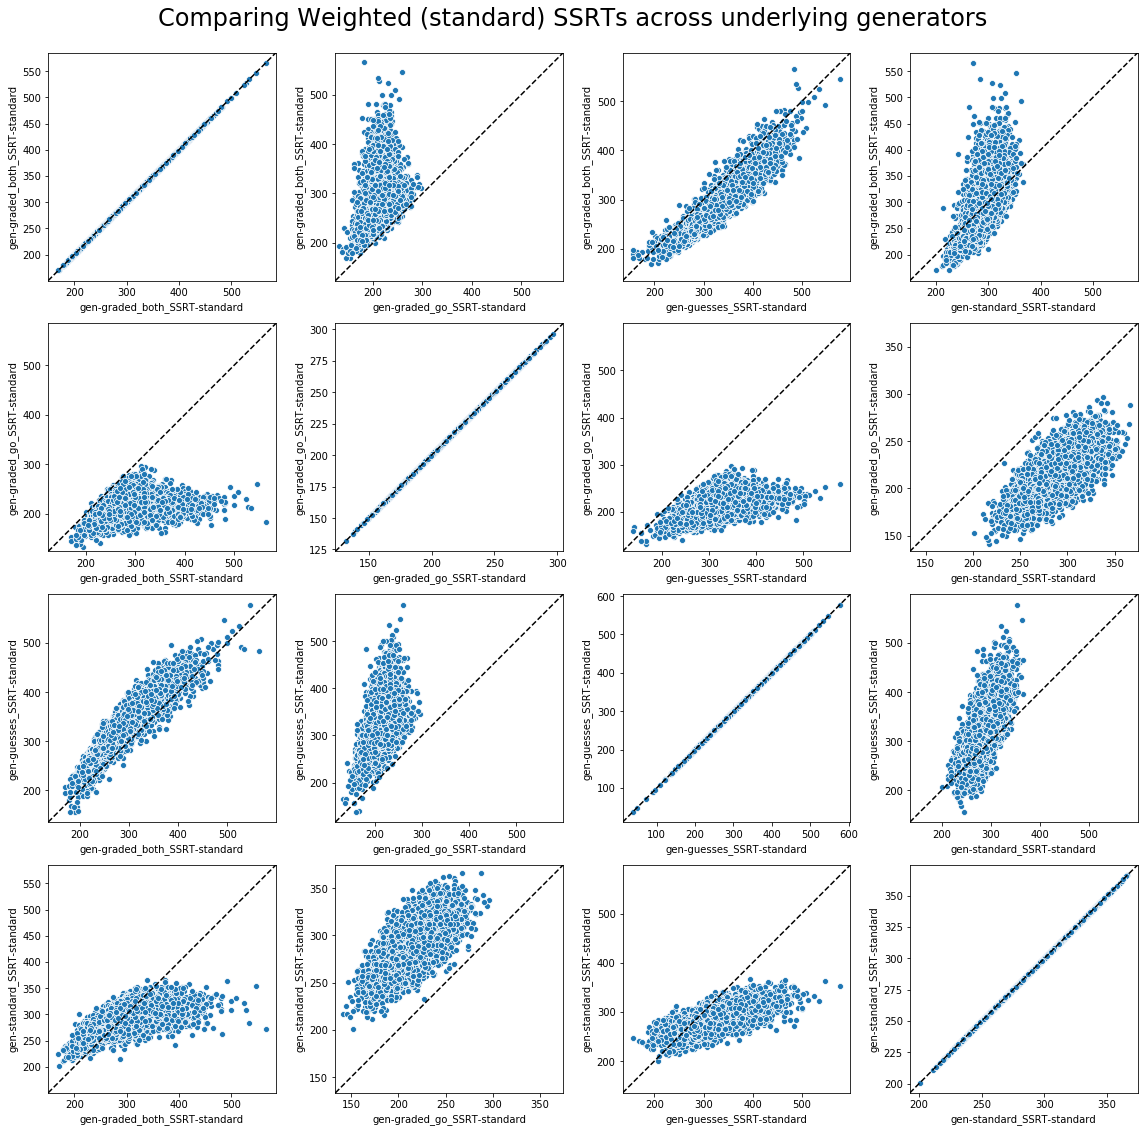

In [18]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [19]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                       1.000000   
gen-graded_go_SSRT-standard                         0.362680   
gen-guesses_SSRT-standard                           0.928566   
gen-standard_SSRT-standard                          0.729579   

                               gen-graded_go_SSRT-standard  \
gen-graded_both_SSRT-standard                     0.362680   
gen-graded_go_SSRT-standard                       1.000000   
gen-guesses_SSRT-standard                         0.426973   
gen-standard_SSRT-standard                        0.661255   

                               gen-guesses_SSRT-standard  \
gen-graded_both_SSRT-standard                   0.928566   
gen-graded_go_SSRT-standard                     0.426973   
gen-guesses_SSRT-standard                       1.000000   
gen-standard_SSRT-standard                      0.712720   

                               gen-standard_SSRT-standard  
gen-graded_both_SSRT-standard                    0.729579  
gen-graded_go_SSRT-standard                      0.661255  
gen-guesses_SSRT-standard                        0.712720  
gen-standard_SSRT-standard                       1.000000

## not rescaling axis to get a closer look

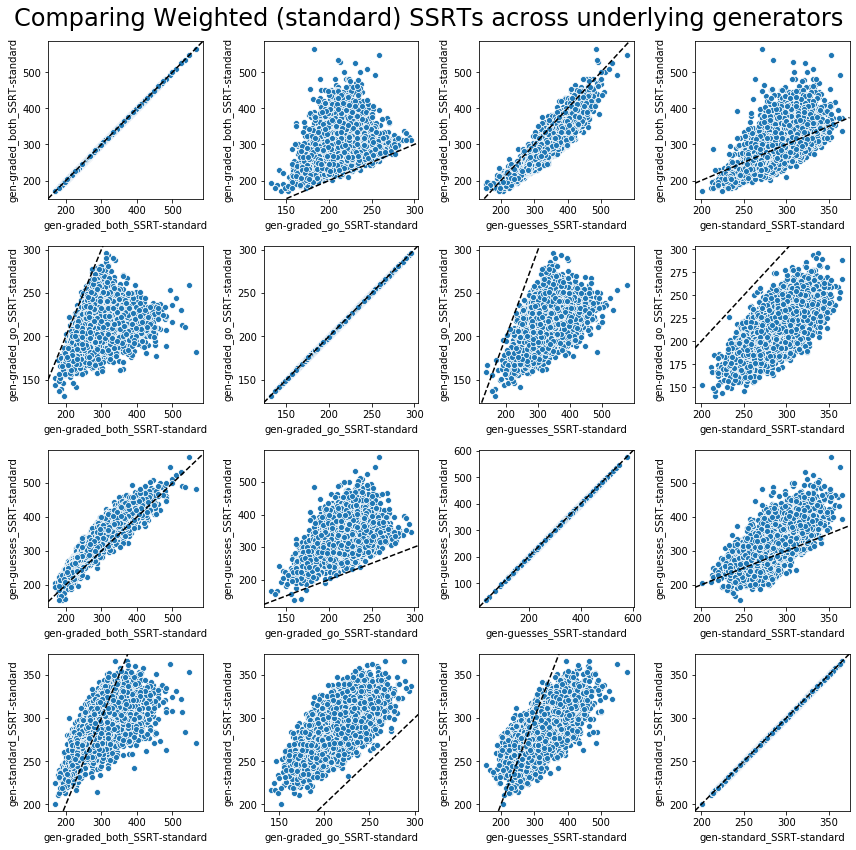

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

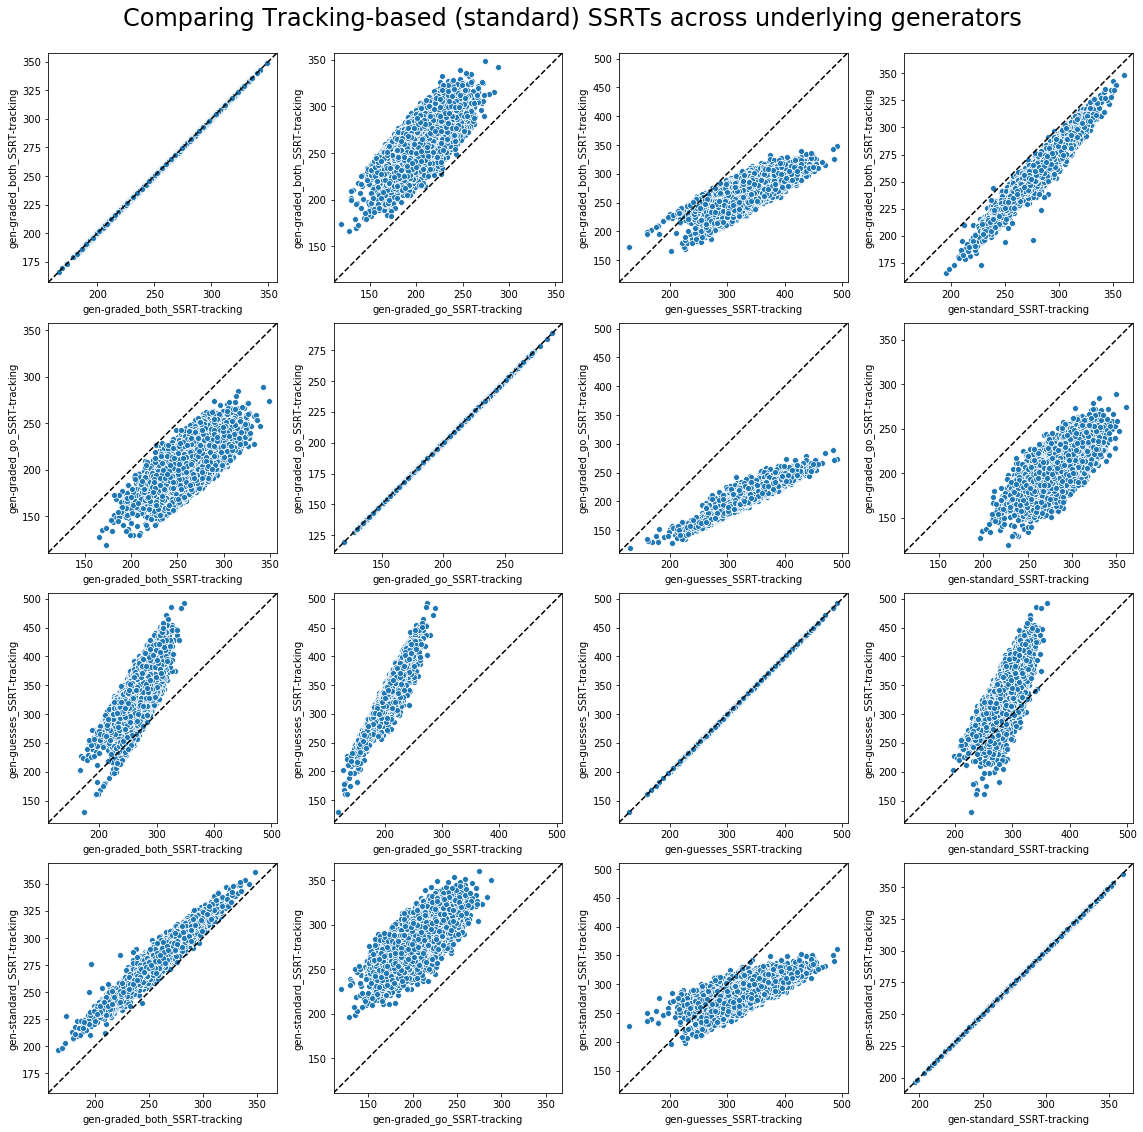

In [21]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [22]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-tracking  \
gen-graded_both_SSRT-tracking                       1.000000   
gen-graded_go_SSRT-tracking                         0.644944   
gen-guesses_SSRT-tracking                           0.719690   
gen-standard_SSRT-tracking                          0.965084   

                               gen-graded_go_SSRT-tracking  \
gen-graded_both_SSRT-tracking                     0.644944   
gen-graded_go_SSRT-tracking                       1.000000   
gen-guesses_SSRT-tracking                         0.943877   
gen-standard_SSRT-tracking                        0.677161   

                               gen-guesses_SSRT-tracking  \
gen-graded_both_SSRT-tracking                   0.719690   
gen-graded_go_SSRT-tracking                     0.943877   
gen-guesses_SSRT-tracking                       1.000000   
gen-standard_SSRT-tracking                      0.754172   

                               gen-standard_SSRT-tracking  
gen-graded_both_SSRT-tracking                    0.965084  
gen-graded_go_SSRT-tracking                      0.677161  
gen-guesses_SSRT-tracking                        0.754172  
gen-standard_SSRT-tracking                       1.000000

## not rescaling axes

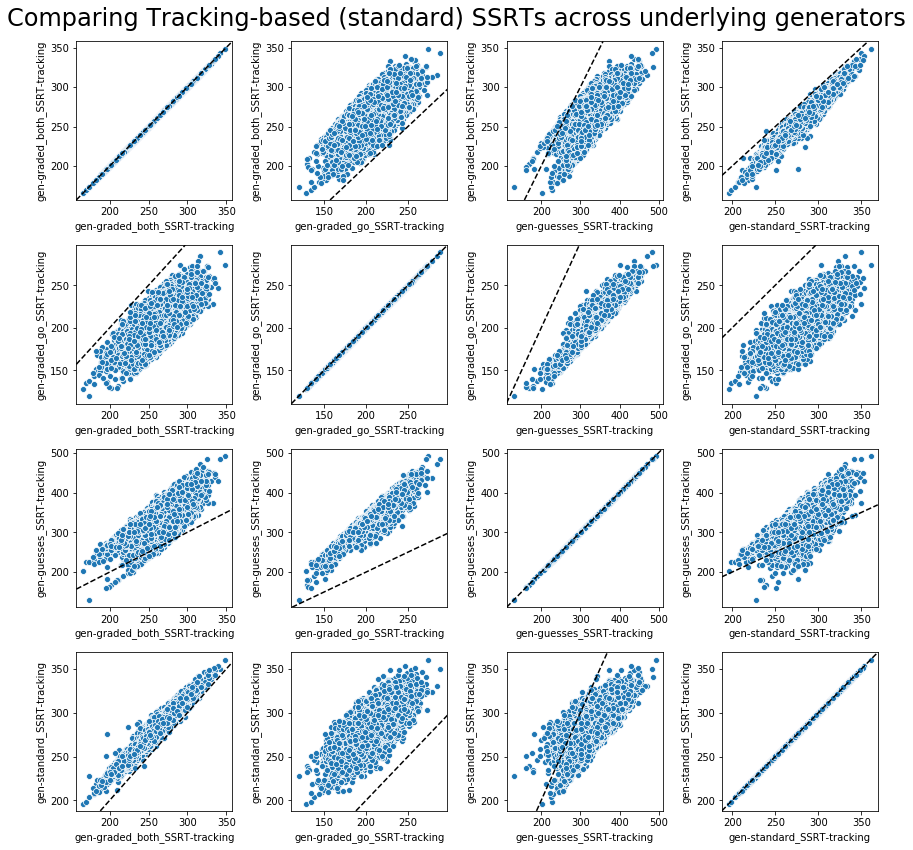

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [24]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

assigned_SSRT  gen-graded_both_SSRT-standard  \
count    8207.000000                    8184.000000   
mean      301.558284                     277.535177   
std        24.904469                      44.833988   
min       204.551478                     169.833333   
25%       285.065265                     247.829167   
50%       301.515191                     268.184259   
75%       318.176920                     296.487500   
max       403.580206                     565.333333   

       gen-graded_go_SSRT-standard  gen-guesses_SSRT-standard  \
count                  8171.000000                8205.000000   
mean                    213.483913                 320.012966   
std                      20.908117                  47.674296   
min                     131.666667                  37.833333   
25%                     199.016808                 289.155172   
50%                     212.983333                 314.683333   
75%                     227.525000                 346.333333   
max                     296.387755                 577.783333   

       gen-standard_SSRT-standard  gen-graded_both_SSRT-fixed  \
count                 8175.000000                 8207.000000   
mean                   287.092251                  276.088461   
std                     21.710634                   26.964058   
min                    200.854545                  103.000000   
25%                    272.533333                  259.000000   
50%                    286.916667                  277.000000   
75%                    301.796453                  294.500000   
max                    366.133333                  371.000000   

       gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
count               8207.000000             8207.000000   
mean                 211.848788              332.497137   
std                   20.091126               45.231290   
min                   71.000000               65.000000   
25%                  199.000000              304.000000   
50%                  213.000000              335.000000   
75%                  226.000000              363.000000   
max                  279.000000              496.000000   

       gen-standard_SSRT-fixed  gen-graded_both_SSRT-tracking  \
count              8207.000000                    8207.000000   
mean                285.076520                     260.478595   
std                  21.678668                      23.898317   
min                 145.000000                     166.146000   
25%                 271.000000                     244.611000   
50%                 286.000000                     260.634000   
75%                 300.000000                     276.640000   
max                 369.000000                     348.608000   

       gen-graded_go_SSRT-tracking  gen-guesses_SSRT-tracking  \
count                  8207.000000                8207.000000   
mean                    205.545464                 334.729153   
std                      21.226282                  39.473226   
min                     119.368000                 129.630000   
25%                     190.846000                 308.508000   
50%                     205.898000                 335.084000   
75%                     219.800000                 361.160000   
max                     288.686000                 491.992000   

       gen-standard_SSRT-tracking  
count                 8207.000000  
mean                   281.315222  
std                     21.419480  
min                    196.148000  
25%                    267.103000  
50%                    281.706000  
75%                    295.887000  
max                    360.752000

In [25]:
ssrt_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                          1.000000   
gen-graded_go_SSRT-standard.1                          0.362680   
gen-guesses_SSRT-standard.2                            0.928566   
gen-standard_SSRT-standard.3                           0.729579   
gen-graded_both_SSRT-guesses                           0.510666   
gen-graded_go_SSRT-guesses.1                          -0.481323   
gen-guesses_SSRT-guesses.2                             0.605923   
gen-standard_SSRT-guesses.3                           -0.318742   
gen-graded_both_SSRT-graded_go                         0.700818   
gen-graded_go_SSRT-graded_go.1                         0.460638   
gen-guesses_SSRT-graded_go.2                           0.717716   
gen-standard_SSRT-graded_go.3                          0.535995   
gen-graded_both_SSRT-graded_both                       0.700818   
gen-graded_go_SSRT-graded_both.1                       0.460638   
gen-guesses_SSRT-graded_both.2                         0.717716   
gen-standard_SSRT-graded_both.3                        0.535995   
gen-graded_both_SSRT-fixed                             0.645284   
gen-graded_go_SSRT-fixed.1                             0.632378   
gen-guesses_SSRT-fixed.2                               0.593276   
gen-standard_SSRT-fixed.3                              0.615414   
gen-graded_both_SSRT-tracking                          0.451999   
gen-graded_go_SSRT-tracking.1                          0.636395   
gen-guesses_SSRT-tracking.2                            0.633377   
gen-standard_SSRT-tracking.3                           0.475835   

                                  gen-graded_go_SSRT-standard.1  \
gen-graded_both_SSRT-standard                          0.362680   
gen-graded_go_SSRT-standard.1                          1.000000   
gen-guesses_SSRT-standard.2                            0.426973   
gen-standard_SSRT-standard.3                           0.661255   
gen-graded_both_SSRT-guesses                           0.359332   
gen-graded_go_SSRT-guesses.1                           0.528370   
gen-guesses_SSRT-guesses.2                             0.690124   
gen-standard_SSRT-guesses.3                            0.319248   
gen-graded_both_SSRT-graded_go                        -0.145259   
gen-graded_go_SSRT-graded_go.1                         0.336359   
gen-guesses_SSRT-graded_go.2                          -0.104070   
gen-standard_SSRT-graded_go.3                         -0.138213   
gen-graded_both_SSRT-graded_both                      -0.145259   
gen-graded_go_SSRT-graded_both.1                       0.336359   
gen-guesses_SSRT-graded_both.2                        -0.104070   
gen-standard_SSRT-graded_both.3                       -0.138213   
gen-graded_both_SSRT-fixed                             0.838753   
gen-graded_go_SSRT-fixed.1                             0.854429   
gen-guesses_SSRT-fixed.2                               0.760492   
gen-standard_SSRT-fixed.3                              0.849784   
gen-graded_both_SSRT-tracking                          0.670722   
gen-graded_go_SSRT-tracking.1                          0.847500   
gen-guesses_SSRT-tracking.2                            0.854602   
gen-standard_SSRT-tracking.3                           0.698311   

                                  gen-guesses_SSRT-standard.2  \
gen-graded_both_SSRT-standard                        0.928566   
gen-graded_go_SSRT-standard.1                        0.426973   
gen-guesses_SSRT-standard.2                          1.000000   
gen-standard_SSRT-standard.3                         0.712720   
gen-graded_both_SSRT-guesses                         0.294845   
gen-graded_go_SSRT-guesses.1                        -0.468161   
gen-guesses_SSRT-guesses.2                           0.603542   
gen-standard_SSRT-guesses.3                         -0.402090   
gen-graded_both_SSRT-graded_go                       0.577271   
gen-graded_go_SSRT-graded_go.1  

## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null. Not sure if you want me to fix.

In [26]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 8175
gen-standard_SSRT-guesses 8175
gen-standard_SSRT-graded_go 8175
gen-standard_SSRT-graded_both 8175
gen-guesses_SSRT-standard 8205
gen-guesses_SSRT-guesses 8205
gen-guesses_SSRT-graded_go 8205
gen-guesses_SSRT-graded_both 8205
gen-graded_go_SSRT-standard 8171
gen-graded_go_SSRT-guesses 8171
gen-graded_go_SSRT-graded_go 8171
gen-graded_go_SSRT-graded_both 8171
gen-graded_both_SSRT-standard 8184
gen-graded_both_SSRT-guesses 8184
gen-graded_both_SSRT-graded_go 8184
gen-graded_both_SSRT-graded_both 8184


In [27]:
ssrt_df.filter(regex='SSRT-tracking').describe()

gen-graded_both_SSRT-tracking  gen-graded_go_SSRT-tracking.1  \
count                    8207.000000                    8207.000000   
mean                      260.478595                     205.545464   
std                        23.898317                      21.226282   
min                       166.146000                     119.368000   
25%                       244.611000                     190.846000   
50%                       260.634000                     205.898000   
75%                       276.640000                     219.800000   
max                       348.608000                     288.686000   

       gen-guesses_SSRT-tracking.2  gen-standard_SSRT-tracking.3  
count                  8207.000000                   8207.000000  
mean                    334.729153                    281.315222  
std                      39.473226                     21.419480  
min                     129.630000                    196.148000  
25%                     308.508000                    267.103000  
50%                     335.084000                    281.706000  
75%                     361.160000                    295.887000  
max                     491.992000                    360.752000